# Library

In [67]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score

# Configration

In [104]:
grid_search_flag = 1
estimater_model = 'rf'
lr_params_grid = {
    'C': [1e-2, 1e-1, 1, 1e1, 1e2]
}
rf_params_grid = {
    
}
threshold_grid = [f / 10 for f in list(range(1, 10, 1))]

# Import data

In [105]:
target_file = './data/input/input_add_rank.csv'

df_data = pd.read_csv(target_file)
df_data = df_data.set_index(['horse_id'])

In [106]:
print(df_data.head())
print(df_data.shape)

            target    1g_ago    2g_ago    3g_ago    4g_ago    5g_ago  \
horse_id                                                               
1988105984     0.0  0.600000  0.333333  0.066667  0.538462  0.083333   
1991103531     0.0  0.461538  0.666667  0.375000       NaN       NaN   
1991190011     0.0       NaN       NaN       NaN       NaN       NaN   
1992100038     0.0  0.555556  0.636364  0.375000  0.333333  0.833333   
1992101546     0.0  0.285714  0.250000  0.250000  0.750000  0.333333   

            rank_glass  rank_dirt      rank  
horse_id                                     
1988105984         NaN   0.403643  0.403643  
1991103531    0.777778   0.501068  0.570246  
1991190011    0.562500        NaN  0.562500  
1992100038    0.485277   0.480977  0.484891  
1992101546    0.405078   0.458542  0.424120  
(106845, 9)


# Preprocessing

In [107]:
df_data.isnull().sum()

target            0
1g_ago         4171
2g_ago         9214
3g_ago        14241
4g_ago        18837
5g_ago        23010
rank_glass    21141
rank_dirt     11251
rank              0
dtype: int64

#### 2022/11/23
- 6試合以上の成績が残っていない馬は除外

In [108]:
df_data = df_data[df_data['5g_ago'].notnull()]
df_data.head()
#df_input.head()
#df_data.fillna(0.5, inplace=True)
#df_temp.head()
#df_data = df_data.dropna(subset=drop_list)
#df_data = pd.concat([df_temp, df_data[['target']]], axis=1)

,target,1g_ago,2g_ago,3g_ago,4g_ago,5g_ago,rank_glass,rank_dirt,rank
horse_id,,,,,,,,,
1988105984,0.0,0.600000,0.333333,0.066667,0.538462,0.083333,NaN,0.403643,0.403643
1992100038,0.0,0.555556,0.636364,0.375000,0.333333,0.833333,0.485277,0.480977,0.484891
1992101546,0.0,0.285714,0.250000,0.250000,0.750000,0.333333,0.405078,0.458542,0.424120
1992102844,0.0,0.666667,0.588235,0.266667,0.625000,0.416667,0.421091,0.928571,0.435187
1992104930,0.0,0.833333,0.900000,0.900000,0.800000,0.333333,0.802564,0.504846,0.524476


### NaNを平均値で補完

In [123]:
df_data = df_data.fillna(df_data.mean())

In [124]:
df_x = df_data.iloc[:, 1:]
df_y = df_data.iloc[:, 0]

In [125]:
df_y

horse_id
1988105984    0.0
1992100038    0.0
1992101546    0.0
1992102844    0.0
1992104930    0.0
             ... 
2020106981    0.0
2020107146    1.0
2020109061    0.0
2020109133    0.0
2020109153    0.0
Name: target, Length: 83835, dtype: float64

In [126]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, random_state=0)

print('# train 0 : ', len(y_train[y_train==0]))
print('# train 1 : ', len(y_train[y_train==1]))

print('# test 0 : ', len(y_test[y_test==0]))
print('# test 0 : ', len(y_test[y_test==1]))

# train 0 :  63102
# train 1 :  3966
# test 0 :  15775
# test 0 :  992


/usr/local/Caskroom/miniforge/base/envs/share-envs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

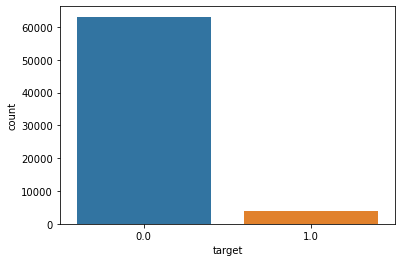

In [127]:
sns.countplot(y_train)

/usr/local/Caskroom/miniforge/base/envs/share-envs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

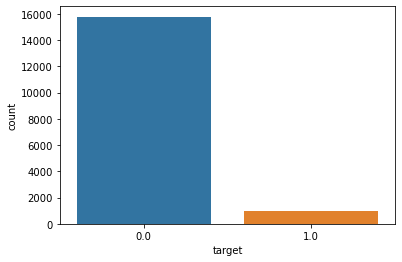

In [128]:
sns.countplot(y_test)

# Pipeline

In [129]:
from sklearn.pipeline import make_pipeline
model_lrbl = LogisticRegression(penalty='l2', random_state=0, class_weight='balanced')
model_lrno = LogisticRegression(penalty='l2', random_state=0, class_weight=None)
model_rf = RandomForestClassifier(n_estimators=100, rando_state=0, class_weight='balanced')
#pipe_lrbl = make_pipeline(StandardScaler(), model_lrbl)
#pipe_lrno = make_pipeline(StandardScaler(), model_

- weightをNoneにするとtarget0のデータに過学習してしまい、確率が小さい値に寄ってしまった。（気になるようだったら試してみてください）

In [130]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [131]:
if grid_search_flag:
    clf = GridSearchCV(estimator=model_lrbl, param_grid=params_grid, scoring='roc_auc', cv=10, n_jobs=-1, error_score='raise')
    clf.fit(x_train, y_train)
    best_model = clf.best_estimator_

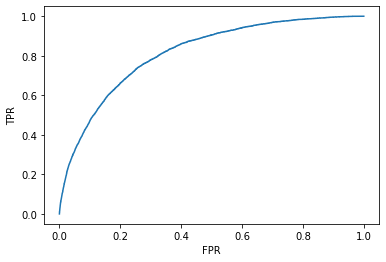

Best AUC score:  0.8120790731557691


In [132]:
y_pred = best_model.predict_proba(x_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

best_score = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
print("Best AUC score: ", best_score)

In [133]:
best_score = 0
best_threshold = 0
for thr in threshold_grid:
    y_pred = (clf.predict_proba(x_train)[:, 1] > thr) * 1
    temp_score = precision_score(y_true=y_train, y_pred=y_pred)
    if best_score < temp_score:
        best_threshold = thr
        best_score = temp_score

print("Best threshold: ", best_threshold)
print("Best precision: ", best_score)

Best threshold:  0.9
Best precision:  0.4234338747099768


In [134]:
best_threshold

0.9

In [135]:
y_pred_test = (clf.predict_proba(x_test)[:,1] > best_threshold ) * 1
print('precision：', precision_score(y_true=y_test, y_pred=y_pred_test))
print('recall：', recall_score(y_true=y_test, y_pred=y_pred_test))
print('f1 score：', f1_score(y_true=y_test, y_pred=y_pred_test))
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_test))

precision： 0.39631336405529954
recall： 0.08669354838709678
f1 score： 0.1422663358147229
confusion matrix = 
 [[15644   131]
 [  906    86]]


# train, testそれぞれのProbabilityを見てみる
## train

<AxesSubplot:ylabel='Count'>

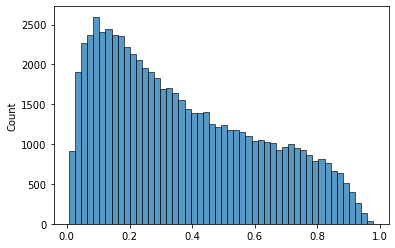

In [136]:
y_pred_train = clf.predict_proba(x_train)[:,1] 
sns.histplot(y_pred_train)

In [137]:
np_y_true_train = y_train.to_numpy()
np_concat = [np_y_true_train, y_pred_train]
df_concat_train = pd.DataFrame(np_concat)
df_concat_train = df_concat_train.T
df_concat_train.head()

,0,1
0,0.0,0.208200
1,0.0,0.114473
2,0.0,0.782148
3,0.0,0.394883
4,0.0,0.320234


<AxesSubplot:xlabel='1', ylabel='Count'>

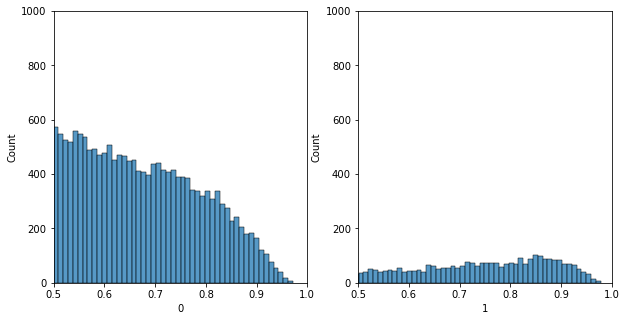

In [138]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].set_xlim(0.5, 1)
ax[0].set_ylim(0, 1000)
ax[0].set_xlabel('0')
ax[1].set_xlim(0.5, 1)
ax[1].set_ylim(0, 1000)
ax[1].set_xlabel('1')
sns.histplot(data=df_concat_train[df_concat_train.iloc[:, 0]==0].iloc[:, 1], ax=ax[0], bins=100)
sns.histplot(data=df_concat_train[df_concat_train.iloc[:, 0]==1].iloc[:, 1], ax=ax[1], bins=100)

## test

<AxesSubplot:xlabel='1', ylabel='Count'>

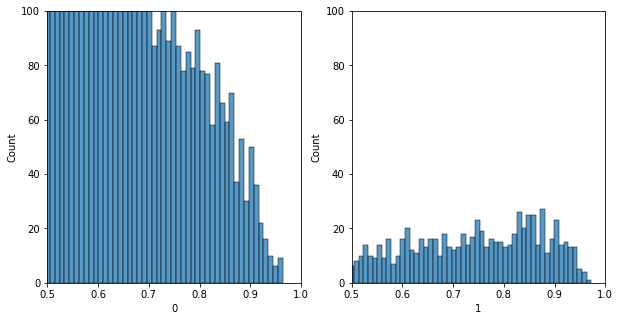

In [139]:
y_pred_test = clf.predict_proba(x_test)[:,1] 
#sns.histplot(y_pred_test)

np_y_true_test = y_test.to_numpy()
np_concat = [np_y_true_test, y_pred_test]
df_concat_test = pd.DataFrame(np_concat)
df_concat_test = df_concat_test.T
df_concat_test.head()

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].set_xlim(0.5, 1)
ax[0].set_ylim(0, 100)
ax[0].set_xlabel('0')
ax[1].set_xlim(0.5, 1)
ax[1].set_ylim(0, 100)
ax[1].set_xlabel('1')
sns.histplot(data=df_concat_test[df_concat_test.iloc[:, 0]==0].iloc[:, 1], ax=ax[0], bins=100)
sns.histplot(data=df_concat_test[df_concat_test.iloc[:, 0]==1].iloc[:, 1], ax=ax[1], bins=100)

### 2022/11/12
- N/Aを0.5で埋めていることが起因しているのかx=0.5付近のcountが多い。
 - 0.5付近の確率となる馬のデータを確認してみる。
 - 補完値を変更 or 一定の試合数の馬のみにデータを絞る 等も試してみる必要がある
  
- 神様であるtestを見ると、このモデルでは上手くthresholdを設定してもprecsionを上げることは難しそう。モデルの変更か相当素晴らしい特徴量を追加する必要がある？\

### 2022/11/23
- トレーニングデータは値補完することを諦め、6試合以上の成績がある馬のみにしぼることでprecisionは0.15→0.25程度に向上した。やはり試合数を重ねた馬でないと予測は難しい気がする